In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pywt
import pywt.data
import copy
import os
import scipy
from scipy import ndimage

In [2]:
# !unzip '/content/images.zip' -d '/content/'

In [3]:
imp_images = ['Lena.jpg' , 'barbara.jpg' , 'cameraman.jpg' , 'peppers.jpg']
test_images = ['girlface.bmp']

In [4]:
imp_path = './images/imp/'
test_path = './images/test/'

## Load Image And Add Gaussian Noise

In [5]:
def create_noisy_image(path , deviation , mean = 0):
    np.random.seed(1)
    img = cv2.imread(path , cv2.IMREAD_GRAYSCALE).astype(dtype=np.float32)
    image_size = img.shape
    gaussian_noise = np.random.normal(mean,deviation,image_size[0]*image_size[1]).astype(dtype=np.float32)
    gaussian_noise = gaussian_noise.reshape((image_size[0],image_size[1]))
    img = img + gaussian_noise
    return img

## Haar Coefficient Of Noisy Image

In [6]:
def Haar(img , level):
    LL = copy.deepcopy(img)
    for i in range(level):
        LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
    return LL , LH , HL , HH

## Edge Map Of Noisy Image

In [7]:
def non_max_suppression(data, win):
    data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

In [8]:
def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    winE = np.array([[0, 0, 0],
                     [1, 1, 1],
                     [0, 0, 0]])
    winSE = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])
    winS = np.array([[0, 1, 0],
                     [0, 1, 0],
                     [0, 1, 0]])
    winSW = np.array([[0, 0, 1],
                      [0, 1, 0],
                      [1, 0, 0]])

    magE = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    mag[ang_quant == 0] = magE[ang_quant == 0]
    mag[ang_quant == 1] = magSE[ang_quant == 1]
    mag[ang_quant == 2] = magS[ang_quant == 2]
    mag[ang_quant == 3] = magSW[ang_quant == 3]
    return mag

In [9]:
def edge_map(gray_image):
  sobelx = cv2.Sobel(gray_image, cv2.CV_32F, 1, 0, ksize=3)
  sobely = cv2.Sobel(gray_image, cv2.CV_32F, 0, 1, ksize=3)
  mag = np.hypot(sobelx, sobely)
  ang = np.arctan2(sobely, sobelx)
  fudgefactor = 0.5
  threshold = 4 * fudgefactor * np.mean(mag)
  mag[mag < threshold] = 0
  mag = orientated_non_max_suppression(mag, ang)
  mag[mag > 0] = True
  mag[mag <= 0] = False
  mag = mag.astype(np.uint8)
  return mag

## Dilate Edge Map

In [10]:
def dilate_EM(img , k):
    kernel = np.ones((k,k))
    dilated = cv2.dilate(img,kernel,iterations=1)
    col , row = int(dilated.shape[0]/2) , int(dilated.shape[1]/2)
    dilated = cv2.resize(dilated,(row , col))
    return dilated

## Initial Estimation Of Noise

In [11]:
def init_estimation(path,sigma):
  img = create_noisy_image(path , sigma)
  LL,LH,HL,HH = Haar(img,1)
  EM = edge_map(img)
  EM_rd = dilate_EM(EM,1)
  EM_rdi = 1 - EM_rd
  W_ne = np.multiply(EM_rdi , HH)
  i , j = HH.shape[0] , HH.shape[1]
  sigma_init = (1/np.sqrt(i*j)) * np.sqrt(np.sum(np.multiply(W_ne,W_ne)))
  return sigma_init

In [12]:
x = [i for i in range(10,201,10)]
estimation = []
for pth in imp_images:
  res = []
  path = imp_path + pth
  for i in x:
    init_sigma = init_estimation(path,i)
    res.append(float(round(init_sigma,2)))
  estimation.append(res)


C:\Users\POORYA\AppData\Local\Temp\ipykernel_1928\1934809113.py:2: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')


In [13]:
print("image name",end='\t')
for i in range(10,201,10):
  print(i,end='\t')
print('\n')
for i,img in enumerate(estimation):
  print(imp_images[i],end='\t')
  for data in img:
    print(data,end="\t")
  print('\n')

image name	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	

Lena.jpg	9.97	19.63	29.48	39.37	49.25	59.16	69.03	78.91	88.77	98.65	108.51	118.39	128.27	138.13	147.98	157.86	167.72	177.61	187.47	197.35	

barbara.jpg	11.77	20.55	30.11	39.89	49.72	59.55	69.4	79.24	89.1	98.92	108.77	118.62	128.46	138.31	148.2	158.06	167.91	177.78	187.67	197.55	

cameraman.jpg	11.42	20.31	29.78	39.58	49.42	59.41	69.38	79.33	89.32	99.34	109.31	119.22	129.14	139.04	148.99	158.95	168.87	178.84	188.82	198.74	

peppers.jpg	9.83	19.54	29.38	39.25	49.13	59.04	68.94	78.83	88.72	98.64	108.51	118.38	128.24	138.13	148.01	157.88	167.75	177.62	187.49	197.35	



In [14]:
est = np.mean(estimation,axis=0)

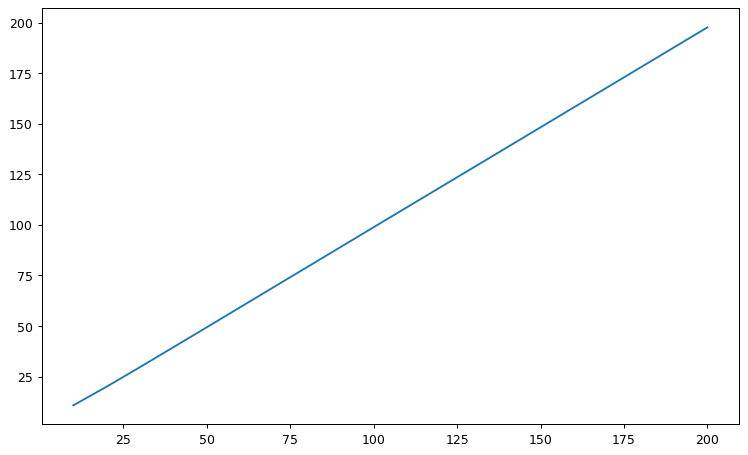

In [15]:
plt.figure(figsize=(10,6),dpi=90)
plt.plot(x,est)

In [16]:
mymodel = np.poly1d(np.polyfit(est,x,1))
mymodel.coef

array([ 1.01291664, -0.20354835])

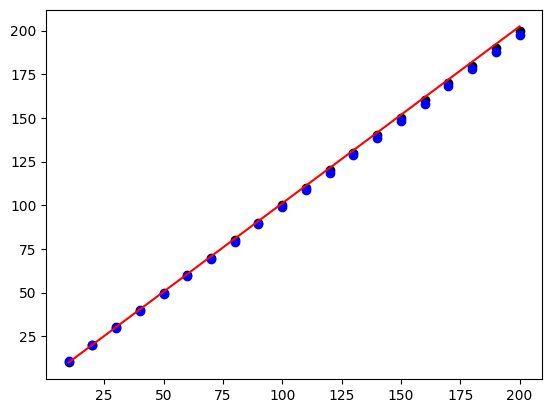

In [17]:
plt.scatter(x, x, color = 'black')
plt.scatter(x, est, color = 'blue')
line = [i for i in range(10,201,10)]
plt.plot(line, mymodel(line), color = 'red')
  
plt.show()

In [18]:
error = (np.abs((mymodel(est) - line)) / line)*100

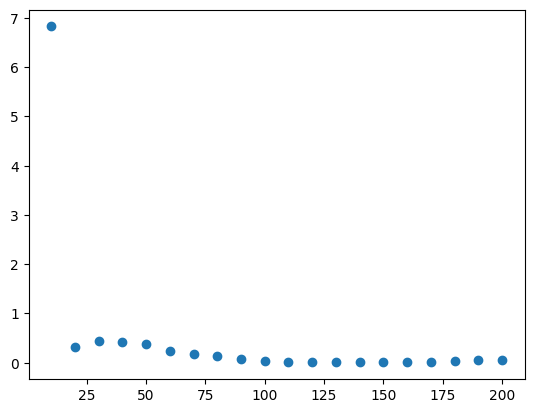

In [19]:
plt.scatter(line,error)

In [20]:
x = [i for i in range(10,5001,10)]
test_estimation = []
for pth in test_images:
  res = []
  path = test_path + pth
  for i in x:
    init_sigma = init_estimation(path,i)
    res.append(float(round(init_sigma,2)))
  test_estimation.append(res)

C:\Users\POORYA\AppData\Local\Temp\ipykernel_1928\1934809113.py:2: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')


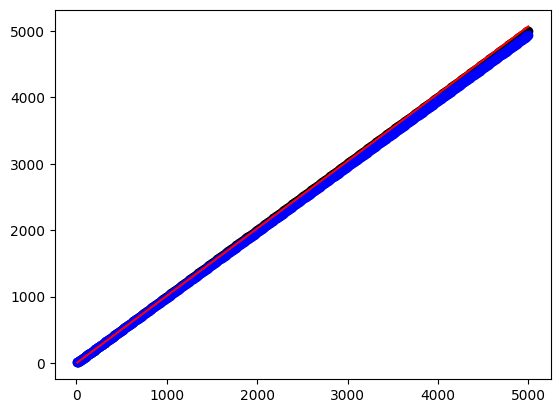

In [21]:
plt.scatter(x, x, color = 'black')
plt.scatter(x, test_estimation, color = 'blue')
plt.plot(x, mymodel(x), color = 'red')
  

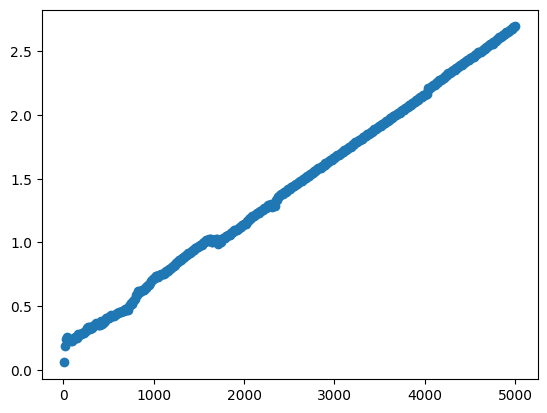

In [22]:
error_value = np.abs((mymodel(test_estimation) - x))
plt.scatter(x,error_value)

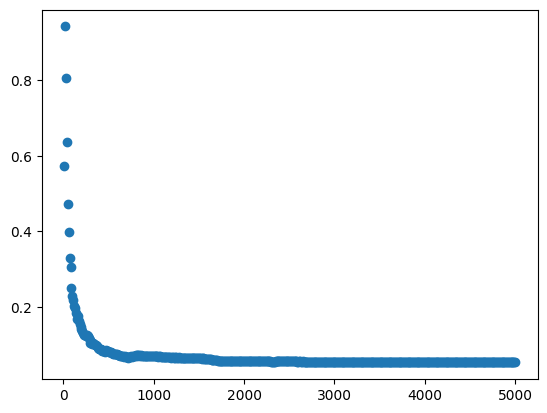

In [23]:
error = (np.abs((mymodel(test_estimation) - x)) / x)*100
plt.scatter(x,error)